In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split



#### Data loading and knowing data

In [2]:
#loading data
taxi_data= pd.read_csv('yellow_taxi_data.csv')
# looking to the data 
print(taxi_data.head(5))


   vendorid     tpep_pickup_datetime    tpep_dropoff_datetime  \
0         2  2023-01-01T00:32:10.000  2023-01-01T00:40:36.000   
1         1  2023-01-01T00:13:10.000  2023-01-01T00:26:15.000   
2         2  2023-01-01T01:41:25.000  2023-01-01T01:51:58.000   
3         2  2023-01-01T02:12:52.000  2023-01-01T02:15:41.000   
4         2  2023-01-01T03:07:13.000  2023-01-01T03:13:45.000   

   passenger_count  trip_distance  ratecodeid store_and_fwd_flag  \
0              1.0           0.97         1.0                  N   
1              1.0           1.40         1.0                  N   
2              1.0           2.65         1.0                  N   
3              1.0           0.74         1.0                  N   
4              2.0           1.43         1.0                  N   

   pulocationid  dolocationid  payment_type  ...  extra  mta_tax  tip_amount  \
0           161           141             2  ...    1.0      0.5        0.00   
1            79           170           

In [3]:
# some informations regrding data - statistics and datatype
print(taxi_data.info()) 
print(taxi_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vendorid               9989 non-null   int64  
 1   tpep_pickup_datetime   9989 non-null   object 
 2   tpep_dropoff_datetime  9989 non-null   object 
 3   passenger_count        9650 non-null   float64
 4   trip_distance          9989 non-null   float64
 5   ratecodeid             9650 non-null   float64
 6   store_and_fwd_flag     9650 non-null   object 
 7   pulocationid           9989 non-null   int64  
 8   dolocationid           9989 non-null   int64  
 9   payment_type           9989 non-null   int64  
 10  fare_amount            9989 non-null   float64
 11  extra                  9989 non-null   float64
 12  mta_tax                9989 non-null   float64
 13  tip_amount             9989 non-null   float64
 14  tolls_amount           9989 non-null   float64
 15  impr

In [4]:
# missing values
missing_values= taxi_data.isnull().sum()
print('The missing values are :' ,missing_values[missing_values> 0])

# unique vlaues to know the data
unique_values_all = {col: taxi_data[col].unique() for col in taxi_data.columns}
for col, uniques in unique_values_all.items():
    print(f"{col}: {uniques}\n")
# we will handle missing values in the prepare the data steps

The missing values are : passenger_count         339
ratecodeid              339
store_and_fwd_flag      339
congestion_surcharge    339
airport_fee             339
pulocation               11
dolocation               42
dtype: int64
vendorid: [2 1 6]

tpep_pickup_datetime: ['2023-01-01T00:32:10.000' '2023-01-01T00:13:10.000'
 '2023-01-01T01:41:25.000' ... '2023-12-28T12:37:02.000'
 '2023-12-30T05:37:21.000' '2023-12-31T18:03:06.000']

tpep_dropoff_datetime: ['2023-01-01T00:40:36.000' '2023-01-01T00:26:15.000'
 '2023-01-01T01:51:58.000' ... '2023-12-28T13:05:55.000'
 '2023-12-30T05:54:09.000' '2023-12-31T18:16:16.000']

passenger_count: [ 1.  2.  3.  4.  6.  5.  0. nan]

trip_distance: [ 0.97  1.4   2.65 ... 11.29  9.51 10.66]

ratecodeid: [ 1.  2.  3.  5. 99. nan  4.]

store_and_fwd_flag: ['N' 'Y' nan]

pulocationid: [161  79 164 263 146 231 230 141 234 186 132 162  68 249 113 170  50  90
 211 239 142 151 229 209 264  43 237 246 262 236 143 114 148 138 100 140
 163  75 238 158 233 107

## Excersise 1

In [5]:
# we have 2 predctions here the project tip_amount and fare_amount
# So we have 2 build 2 seperate preprocccing pipeline for tip_amount and fare_amount

#### Removing rows ( Negative values for attribute and passenger count =0)

In [6]:
# from the data we understand that there are data with passeneger_count=0 and have negative vlaues for other attibutes.
# removing those rows
# Remove rows where passenger_count is 0
taxi_data = taxi_data[taxi_data['passenger_count'] != 0]
num_cols = ['trip_distance','fare_amount','extra','mta_tax','tolls_amount',
            'improvement_surcharge','congestion_surcharge','airport_fee']    
# Keep rows where values are either NaN or >= 0
for col in num_cols:
    taxi_data= taxi_data[(taxi_data[col].isna()) | (taxi_data[col] >= 0)]


taxi_data.shape


(9754, 21)

#### Analysig the histogram for selecting scaling to be used

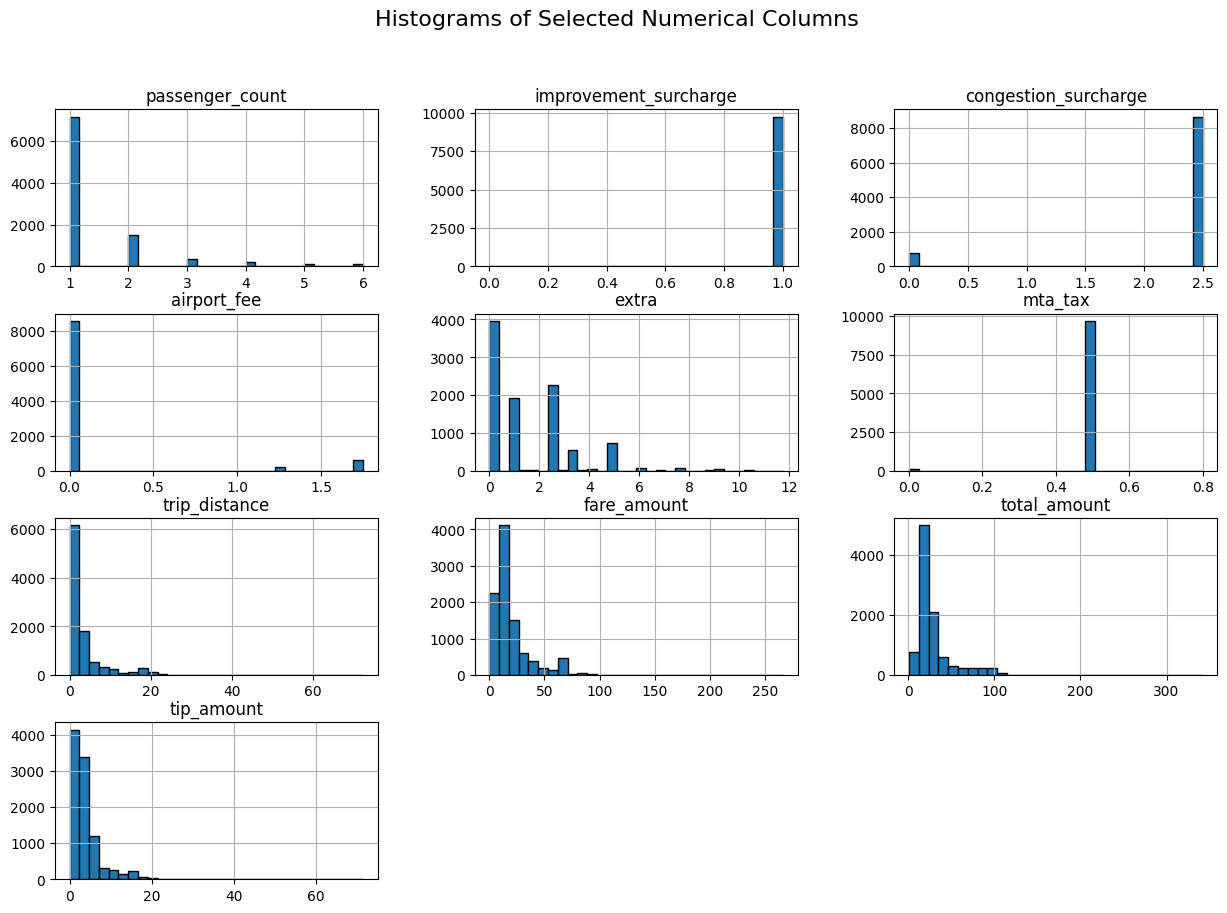

In [7]:
# List of numerical columns
numerical_cols = ['passenger_count','improvement_surcharge', 'congestion_surcharge',
                  'airport_fee','extra', 'mta_tax','trip_distance','fare_amount', 'total_amount', 'tip_amount']

# Histograms
taxi_data[numerical_cols].hist(figsize=(15,10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Selected Numerical Columns', fontsize=16)
plt.show()

Scaling selection : 
- Robust Scaling :tip amount, fare amount, total_amount , trip_distance ( skewed and have outliers)
- MinMx : Extra , its bounded to a range and no scaling for others mostly. 
- But here in the question 3 and 4 we are dealing with lasso regularizer which is sensitive to scaling .
- So its always better to use same scaling range, here choosing robust.
- some IDs represented subzones within a single name, then dropping IDs could lose granularity → less precise modeling.Although some numeric features such as passenger_count and surcharges are categorical-like and do not strictly require scaling, we applied RobustScaler uniformly across all numeric features for simplicity and consistency in Lasso regression. This ensures comparable feature magnitudes, while RobustScaler’s median/IQR transformation minimizes the impact of outliers in continuous variables such as fare_amount and trip_distance.


Columns to be removed:
- 'tpep_pickup_datetime','tpep_dropoff_datetime' : we are not using the direct row values, so we can drop this. Extracted features from this
- Other reduntant columns are there, so we also need to remove that or excclude that from the Pipeline
- pulocation and pulocation_id , reduntant so dropping pulocation
- dolocation and dolocation_id, redunatant so dropping  dolocation
-  IDs represented subzones within a single location, then dropping IDs could lose granularity ,less precise modeling.

#### preprocessing for tip_amount

In [ ]:
class Date_time_total_encoder(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass  # nothing to initialize
        
    def fit(self, X, y=None): 
        return self  # nothing else to do
    
    def transform(self, X):
        X = X.copy()
        
        # Encoding date with the respective day of the week
        pickup_day_of_week = pd.to_datetime(X['tpep_pickup_datetime'], errors='coerce').dt.day_name()
        
        pickup_hours = pd.to_datetime(X['tpep_pickup_datetime'], errors='coerce').dt.hour.astype(float)
        pickup_time_of_day = pd.cut(pickup_hours,
                                    bins=[0, 12, 17, 19, 24],
                                    labels=['Morning','Afternoon','Evening','Night'],
                                    right=False)
        
        # Create pre_tip_total_amount
        X['pre_tip_total_amount'] = (
            X['fare_amount'] + X['extra'] + X['mta_tax'] + X['tolls_amount'] +
            X['improvement_surcharge'] + X['congestion_surcharge'] + X['airport_fee']
        )
        
        X['pickup_time_of_day'] = pickup_time_of_day
        X['pickup_day_of_week'] = pickup_day_of_week
        
        # Drop original datetime columns
        X = X.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1)
        
        return X


In [8]:
date_time_pre_transformer = Date_time_total_encoder()

NameError: name 'Date_time_total_encoder' is not defined

Preventing dataleakage:
- To prevent data leakage the , the total_amount column is removed , as it is the sum of fare and tip

In [ ]:
# preproccing tip_amount

#-----------------------------split the fearutes and data--------------------------

# Step 1: Split features and target
X_train_tip, X_test_tip = train_test_split(taxi_data, test_size=0.2,
                                  random_state=0)
X_train_tip_features = X_train_tip.drop(columns=['tip_amount'])  
y_train_tip = X_train_tip['tip_amount'].copy()    

X_test_features_tip = X_test_tip.drop(columns=['tip_amount'])  
y_test_tip = X_test_tip['tip_amount'].copy() 

#------defining the numerical columns-----------------------------------------------------
# removing the total_amount from numerical column , as there is high corrlation between the tip_amount and total_aount


tip_robust_numeric_features =['passenger_count','improvement_surcharge', 'congestion_surcharge','airport_fee','extra', 'mta_tax','trip_distance','fare_amount','pre_tip_total_amount']
#tip_min_max_numeric_features = ['extra', 'mta_tax']
#tip_robust_numeric_features =['trip_distance','fare_amount','tolls_amount','pre_tip_total_amount']
#tip_no_scale_numeric_features = ['passenger_count','improvement_surcharge', 'congestion_surcharge','airport_fee']

#---------defining the catogorical columns-----------------------------------------------
# categorical_features : includes the catogorical column and some int64 , after inspcetung their values.
tip_categorical_features = [
    'vendorid', 'ratecodeid', 'store_and_fwd_flag',
    'payment_type',
    'pickup_day_of_week', 'pickup_time_of_day',
    'pulocationid', 'dolocationid' ]

# a small percent of value is only missing so I think, its better to ipute than removing the values

#---------------------Pipelines for numeric features---------------------------
numeric_robust_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])



#---------------------Pipeline for categorical features -----------------------------------
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all pipelines in ColumnTransformer
preprocessor = ColumnTransformer([
    ('num_robust', numeric_robust_pipeline, tip_robust_numeric_features),
    ('cat', categorical_pipeline, tip_categorical_features)
])

full_pipeline = Pipeline([
    ('date_time_pre_transformer', date_time_pre_transformer),
    ('preprocessor', preprocessor)
])



#### preprocessing for fare_amount

- Pre_tip_toatl_amount calculation require the fare_amount. Here we are considering the target as Fare_amount, so removing its calculation and usage
- Data leakage can happen in due to total_amount , so not selecting this column as well

In [ ]:
class Date_time_total_fare_encoder(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass  # nothing to initialize
        
    def fit(self, X, y=None): 
        return self  # nothing else to do
    
    def transform(self, X):
        X = X.copy()
        
        # Encoding date with the respective day of the week
        pickup_day_of_week = pd.to_datetime(X['tpep_pickup_datetime'], errors='coerce').dt.day_name()
        
        pickup_hours = pd.to_datetime(X['tpep_pickup_datetime'], errors='coerce').dt.hour.astype(float)
        pickup_time_of_day = pd.cut(pickup_hours,
                                    bins=[0, 12, 17, 19, 24],
                                    labels=['Morning','Afternoon','Evening','Night'],
                                    right=False)
    
        
        X['pickup_time_of_day'] = pickup_time_of_day
        X['pickup_day_of_week'] = pickup_day_of_week
        
        # Drop original datetime columns
        X = X.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1)
        
        return X


In [ ]:
date_time_pre_fare_transformer = Date_time_total_fare_encoder()

In [ ]:
# preproccing fare_amount

#-----------------------------split the fearutes and data--------------------------

# Step 1: Split features and target
X_train_fare, X_test_fare = train_test_split(taxi_data, test_size=0.2,
                                  random_state=0)
X_train_fare_features = X_train_fare.drop(columns=['fare_amount'])  
y_train_fare = X_train_fare['fare_amount'].copy()    

X_test_fare_feature = X_test_fare.drop(columns=['fare_amount'])  
y_test_fare = X_test_fare['fare_amount'].copy() 

#------defining the numerical columns-----------------------------------------------------

fare_robust_numeric_features =['passenger_count','improvement_surcharge', 'congestion_surcharge','airport_fee','extra', 'mta_tax','trip_distance','tolls_amount','tip_amount']
#---------defining the catogorical columns-----------------------------------------------
# categorical_features : includes the catogorical column and some int64 , after inspcetung their values.
fare_categorical_features = [
    'vendorid', 'ratecodeid', 'store_and_fwd_flag',
    'payment_type',
    'pickup_day_of_week', 'pickup_time_of_day',
    'pulocationid', 'dolocationid'    
]

# a small percent of value is only missing so I think, its better to ipute than removing the values

#---------------------Pipelines for numeric features---------------------------
fare_numeric_robust_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#---------------------Pipeline for categorical features -----------------------------------
fare_categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all pipelines in ColumnTransformer
fare_preprocessor = ColumnTransformer([
    ('num_robust', fare_numeric_robust_pipeline, fare_robust_numeric_features),
    ('cat', fare_categorical_pipeline, fare_categorical_features)
])

fare_full_pipeline = Pipeline([
    ('date_time_pre_fare_transformer', date_time_pre_fare_transformer),
    ('preprocessor', fare_preprocessor)
])




Exercise 2 - Exploratory Data Analysis
In this exercise carry exploratory data analysis to understand the data, including:

Pearson's correlation coefficient. In exercise 2 and 3, you will predict attributes tip_amount and fare_amount.
Which pickup location bring the most tips? (Don't forget to normalize by number of fares.)
How are the tip distribution affect as a function of time of the day? Day of the week? Time of the day AND day of the week? (e.g. Friday night, Monday morning, etc.)

## Exercise 2
EDA is carried on  the Main dataset taxi_data (after removing the bad rows)

#### Exercise 2.1 pearson correlation

In [ ]:
dt_transformer = Date_time_total_encoder()
taxi_data_transformed = dt_transformer.transform(taxi_data)
# Numeric columns
numeric_cols = ['passenger_count','improvement_surcharge', 'congestion_surcharge','airport_fee','extra', 'mta_tax',
                'trip_distance','fare_amount','tolls_amount','total_amount','tip_amount','pre_tip_total_amount']

# Compute correlation matrix
corr_matrix = taxi_data_transformed[numeric_cols].corr()

# Correlation sorted with target
corr_tip = corr_matrix['tip_amount'].sort_values(ascending=False)
corr_fare = corr_matrix['fare_amount'].sort_values(ascending=False)


print("Correlation with tip_amount:\n")
print(corr_tip.to_frame())
print("\nCorrelation with fare_amount:\n")
print(corr_fare.to_frame())

# plotting correlation matrix
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()




- For tip amount , highly correlated datas are total_amount, pre_tip_total_amount ,fare_amount , trip_distnace
- For fare amount , highly correlated datas are  pre_tip_total_amount,total_amount,trip_distance, tolls_amount


In [ ]:
# which location bring most tips
pickup_tips = taxi_data.groupby('pulocation')['tip_amount'].mean().sort_values(ascending=False)
print("Top pickup locations by average tip:\n", pickup_tips.head(1))


#### Exercise 2.2 loaction bring most tips

- Top pickup locations by average tip is Queens.
- Here I am using the pulocation, as the question asked reagrding loaction.


#### Exercise 2.3  tip 

In [ ]:
# average tip by time of day
tips_by_time_of_day = taxi_data_transformed.groupby('pickup_time_of_day')['tip_amount'].mean().sort_values(ascending=False)
print("Average tip by time of day:\n", tips_by_time_of_day )



In [ ]:
# average tip by day of the week
tips_by_day = taxi_data_transformed.groupby('pickup_day_of_week')['tip_amount'].mean().sort_values(ascending=False)
print("Average tip by day of the week:\n", tips_by_day)



In [ ]:
tip_time_day = taxi_data_transformed.groupby(
    ["pickup_day_of_week", "pickup_time_of_day"]
)["tip_amount"].mean().unstack()
print(tip_time_day)


- Afternoon tips for time of day
    - Afternoon trips give the highest average tips, followed closely by Night and Evening.
    - Morning trips give slightly lower tips on average.
    - working Afternoon–Night shifts may maximize tips.
- Afternoon tips for day of week
    - Thursday and Friday are the top days for tips.
    - Saturday has the lowest average tip, surprisingly.
    - focus on working Thursday–Friday to maximize tip potential.
- Afternoon tips for day of week and time of the day
Best specific shifts:Monday Night, Friday Afternoon, Sunday Night.

## Exercise 3

#### linear regrssion without lasso

I am using the K fold CV here , as it's common to use K fold CV for taxi data.
For robustness,  If your dataset is very time-dependent (COVID periods, holidays), you might consider TimeSeriesSplit instead to respect chronological order

In [ ]:
# pipeline
tip_pipeline_lr = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', LinearRegression())
])

# Fit on training data
tip_pipeline_lr.fit(X_train_tip_features, y_train_tip)

# Evaluate with cross-validation (5-fold)
cv_scores = cross_val_score(tip_pipeline_lr, X_train_tip_features, y_train_tip, 
                            cv=5, scoring='r2')

mean_r2 = np.mean(cv_scores)
std_r2 = np.std(cv_scores)
ci_lower = mean_r2 - 1.96 * (std_r2 / np.sqrt(len(cv_scores)))
ci_upper = mean_r2 + 1.96 * (std_r2 / np.sqrt(len(cv_scores)))

print(f"Linear Regression: mean R² = {mean_r2:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")



# Save the entire pipeline
joblib.dump(tip_pipeline_lr, 'tip_linear_model.pkl')

print("Linear Regression pipeline saved as 'tip_linear_model.pkl'")



#### Linear regression with lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

# Define Lasso and hyperparameter grid
lasso = Lasso(max_iter=5000)
param_grid = {'model__alpha': [0.001, 0.005, 0.009, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 100]}  
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Pipeline for Lasso
tip_pipeline_lasso = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', lasso)
])

# Grid search with 5-fold CV
grid_search = GridSearchCV(tip_pipeline_lasso, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_tip_features, y_train_tip)

# Best model and hyperparameter
best_lasso_tip = grid_search.best_estimator_
best_alpha = grid_search.best_params_['model__alpha']
print("Best Lasso alpha:", best_alpha)

# Compute cross-validated R² and 95% CI
cv_scores_lasso = cross_val_score(best_lasso_tip, X_train_tip_features, y_train_tip, 
                                  cv=5, scoring='r2')
mean_r2_lasso = np.mean(cv_scores_lasso)
std_r2_lasso = np.std(cv_scores_lasso)
ci_lower_lasso = mean_r2_lasso - 1.96 * (std_r2_lasso / np.sqrt(len(cv_scores_lasso)))
ci_upper_lasso = mean_r2_lasso + 1.96 * (std_r2_lasso / np.sqrt(len(cv_scores_lasso)))

print(f"Lasso Regression: mean R² = {mean_r2_lasso:.3f}, 95% CI = [{ci_lower_lasso:.3f}, {ci_upper_lasso:.3f}]")

# Save the entire pipeline
joblib.dump(best_lasso_tip, 'tip_linear_lasso_model.pkl')


print("Linear lasso Regression pipeline saved as 'tip_linear_lasso_model.pkl'")


#### Exercise 3 coeffcinet and Justication

In [ ]:
# Numeric features
num_features = tip_robust_numeric_features

# Categorical features: OneHotEncoded
ohe = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(tip_categorical_features)

# Combine all feature names
feature_names = list(num_features) + list(cat_features)

# Linear Regression coefficients
lin_model = tip_pipeline_lr.named_steps['model']
lin_coefs = lin_model.coef_

# Create dataframe
lin_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lin_coefs
})

# Sort by coefficient value (descending)
lin_coef_df = lin_coef_df.sort_values(by='coefficient', ascending=False)

# Display all coefficients
pd.set_option('display.max_rows', None)
print("Linear Regression coefficients sorted by value (desc):\n")
print(lin_coef_df)


In [ ]:
# Get the ColumnTransformer from inside the pipeline
column_transformer = best_lasso_tip.named_steps['preprocessing'].named_steps['preprocessor']

# Get feature names from numeric + onehot
feature_names = column_transformer.get_feature_names_out()

# Lasso model and coefficients
lasso_model = best_lasso_tip.named_steps['model']
lasso_coefs = lasso_model.coef_

print("Number of features:", len(feature_names))
print("Number of coefficients:", len(lasso_coefs))

# Build DataFrame if lengths match
if len(feature_names) == len(lasso_coefs):
    lasso_coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': lasso_coefs
    }).sort_values(by='coefficient', ascending=False)

    pd.set_option('display.max_rows', None)
    print("Lasso Regression coefficients:\n")
    print(lasso_coef_df)
else:
    print("Mismatch! Features vs coefficients.")


#### For each model: how is the tip_amount attribute affected by trip distance, passenger count, pre-tip total amount, other fees, and other variables like pickup day, time slot & location, and vendor of the TPEP provider and adivise to taxi driver to maximize the tip_amount


- Linear model tip_amount attribute affected by:
    - trip distance : co_eff : 0.330324 , tip_amount increses as distance increases
        - advice to driver: cahse long trips , so tip amounts will be high
    - passenger count : -0.061503 , tip_amount decreses as passenger_count increases
        - advice to driver: prefer single rides, group tip less
    - pre-tip total amount : 0.167957 , tip_amount increses  as pre-tip total amount increases
        - advice to driver: High-fare rides usually mean higher tips
    - other fees - improvement_surcharge: 2.14(Fixed), congestion_surcharge : 0.48, extra : 0.23,airport_fee : -0.03,mta_tax : -0.60
        - advice to driver: Focus on busy areas and times for higher tips.
    - pickup day :Tuesday,Thursday, Wedneday , saturday have positive coeff
        - advice to driver :Tuesday & Thursday are good for high tips.
    - time slot : afternoon +ve, evening are positive coeff, morning are highly negative 
        - advice to driver : afternoon and evening rides increases the tip. Morning are worst.
    - location :  pulocationid_134 :8.740149 ,  pulocationid_265 :7.828629 
        - advice to driver : pulocationid_134 and pulocationid_265 increases the tip amount.
    - vendor : VendorID 1: 3.861, VendorID 2 = 4.368, VendorID 6 = -8.229 :
        - advice to driver: Vendor 1 and 2 are best. Vendor 6 is bad for tips
    

- linear model : how much do each one of these attributes contribute to predicting tip_amount
    - Best contributor to predicting tip amount:pulocationid_134 : 8.740149 (positive effect) and  dolocationid_200 : -10.349163 (negative effect.
    - Pickup / Dropoff LocationID : Strongest positive and negative effects.
    - Vendor ID & Payment Type : Significant positive for vendor 1 and 2 , and negative for 6
    - Ratecode & Time Features : Mild effects.
    - Fare & Trip Distance : Surprisingly low influence.


- Linear lasso model tip_amount attribute affected by:
    - trip distance : 0.239908, tip_amount increses as distance increases
        - advice to driver : Drivers should not avoid long rides, since passengers are likely to tip more.
    - passenger count : -0.061174, tip_amount decreses as passenger_count increases
        - advice to driver : Solo passengers may be more profitable in tips than groups.
    - pre-tip total amount : 0.241238,  tip_amount increses  as pre-tip total amoun increases
        - advice to driver : Focus on rides with higher base fares
    - other fees : congestion_surcharge - 0.406072
        -  - advice to driver: Focus on busy areas and times for higher tips.
    - pickup day: thursday and tuesday
        - advice to driver : Tips are better on weekdays, especially Tuesday and Thursdays. Sundays are worst.
    - time slot :morning -ve , afteenoon +ve
        - advice to driver : Afternoon rides give more tips, morning rides are worst .
    - location :pulocationid_138 : 0.883905, pulocationid_230 :0.050231
        - advice to driver :pulocationid_138 and  pulocationid_230 incarses the tip
    - vendor : VendorID 2 only have positive coeff
        - advice to driver : Choose vendorID 2 always for greater tips.
    
- linear lasso model : how much do each one of these attributes contribute to predicting tip_amount
    - Best contributor to predicting tip amount:cat__payment_type_1: 2.595414 (positive effect) and  cat__ratecodeid_99.0: -2.776108 (negative effect).
    - Pickup / Dropoff LocationID : Only one or two pickup or drop off location have positive ffect.
    - Vendor ID and Payment Type : positive for vendor 1  



#### When using Lasso regularizer, which value for the hyperparameter  𝜆 best works for this dataset? 
- Grid search for lasso found that among [0.001, 0.005, 0.009, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 100], the best hyper parmeter is  0.009
- This is a very small value, meaning minimal regularization is optimal for this dataset.

#### Based on the CI for each model, which performs best? Justify your answer.

- tip_amount linear regression model: CI - [0.488, 0.526] , mean R² = 0.507
    - Width = 0.526 − 0.488 = 0.038

- tip_amount linear - lasso model : CI - [0.531, 0.579] , mean R² = 0.555,
    - Width = 0.579 − 0.531 = 0.048
    
- For linear regression model : narrower CI but lower performance. 
- For linear- lasso regression model : slightly wider CI but comapritively higher performance.
- Perfomance wise the best model is linear- lasso regression model (with regularization).
- If you need a more reliable model with less performace you can always choose linear regression model.

#### Which features were excluded in the model with a Lasso regularizer, if any?
- Lasso forces some coefficients exactly to 0.
- Any feature with a coefficient = 0 is excluded from the model, because Lasso treats it as non-influential.


In [ ]:
excluded_features = lasso_coef_df[lasso_coef_df['coefficient'] == 0]['feature'].tolist()
print("Features excluded by Lasso:", excluded_features)

## Excercise 4

We used GridSearchCV to automatically search for the best hyperparameters while using cross-validation to ensure that the selected model generalizes well to unseen data instead of overfitting to a single train-test split

#### fare_amout without lasso

In [ ]:

# pipeline
fare_pipeline_lr = Pipeline([
    ('fare_preprocessing', fare_full_pipeline),
    ('fare_model', LinearRegression())
])

# Fit on training data
fare_pipeline_lr.fit(X_train_fare_features, y_train_fare)

# Evaluate with cross-validation (5-fold)
fl_cv_scores = cross_val_score(fare_pipeline_lr, X_train_fare_features, y_train_fare, 
                            cv=5, scoring='r2')

fl_mean_r2 = np.mean(fl_cv_scores)
fl_std_r2 = np.std(fl_cv_scores)
fl_ci_lower = fl_mean_r2 - 1.96 * (fl_std_r2 / np.sqrt(len(fl_cv_scores)))
fl_ci_upper = fl_mean_r2 + 1.96 * (fl_std_r2 / np.sqrt(len(fl_cv_scores)))

print(f"Fare Linear Regression: mean R² = {fl_mean_r2:.3f}, 95% CI = [{fl_ci_lower:.3f}, {fl_ci_upper:.3f}]")



# Save the entire pipeline
joblib.dump(fare_pipeline_lr, 'fare_linear_model.pkl')

print("Linear Regression pipeline saved as 'fare_linear_model.pkl'")



In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

# Define Lasso and hyperparameter grid
fare_lasso = Lasso(max_iter=5000)
param_grid = {'model__alpha': [0.001, 0.005, 0.009, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]} 
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Pipeline for Lasso
fare_pipeline_lasso = Pipeline([
    ('preprocessing', fare_full_pipeline),
    ('model', fare_lasso)
])

# Grid search with 5-fold CV
grid_search = GridSearchCV(fare_pipeline_lasso, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_fare_features, y_train_fare)

# Best model and hyperparameter
best_lasso_fare = grid_search.best_estimator_
best_alpha = grid_search.best_params_['model__alpha']
print("Best Lasso alpha:", best_alpha)

# Compute cross-validated R² and 95% CI
fare_cv_scores_lasso = cross_val_score(best_lasso_fare, X_train_fare_features, y_train_fare, 
                                  cv=5, scoring='r2')
fare_mean_r2_lasso = np.mean(fare_cv_scores_lasso)
fare_std_r2_lasso = np.std(fare_cv_scores_lasso)
fare_ci_lower_lasso = fare_mean_r2_lasso - 1.96 * (fare_std_r2_lasso / np.sqrt(len(fare_cv_scores_lasso)))
fare_ci_upper_lasso = fare_mean_r2_lasso + 1.96 * (fare_std_r2_lasso / np.sqrt(len(fare_cv_scores_lasso)))

print(f"Fare Linear Regression with lasso: mean R² = {fare_mean_r2_lasso:.3f}, 95% CI = [{fare_ci_lower_lasso:.3f}, {fare_ci_upper_lasso:.3f}]")

# Save the entire pipeline
joblib.dump(best_lasso_fare, 'fare_linear_lasso_model.pkl')


print("Fare Linear Regression pipeline saved as 'fare_linear_lasso_model.pkl'")


In [ ]:
import pandas as pd

# Numeric features used in the robust pipeline
num_features = fare_robust_numeric_features

# Access the OneHotEncoder for categorical features
ohe = fare_full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(fare_categorical_features)

# Combine numeric and categorical feature names
feature_names = list(num_features) + list(cat_features)

# Linear Regression coefficients
lin_model = fare_pipeline_lr.named_steps['fare_model']
lin_coefs = lin_model.coef_

# Create dataframe of features and coefficients
lin_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lin_coefs
})

# Sort by coefficient value descending
lin_coef_df = lin_coef_df.sort_values(by='coefficient', ascending=False)

# Display all coefficients
pd.set_option('display.max_rows', None)
print("Fare Linear Regression coefficients sorted by value (desc):\n")
print(lin_coef_df)


In [ ]:
# Access Lasso model from the best pipeline
lasso_model = best_lasso_fare.named_steps['model']
lasso_coefs = lasso_model.coef_

# Create DataFrame for features and coefficients
lasso_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso_coefs
})

## Sort by actual coefficient values (descending)
lasso_coef_df_sorted = lasso_coef_df.sort_values(by='coefficient', ascending=False)

# Display all coefficients
pd.set_option('display.max_rows', None)
print("Fare Lasso Regression coefficients sorted by coefficient value (desc):\n")
print(lasso_coef_df_sorted)



#### how is the fare attribute affected by trip distance, passenger count, pre-tip total amount, other fees, and other variables like pickup day, time slot & location, and vendor of the TPEP provider and adivise to taxi driver to maximize the fare_amount

Fare and tip are positively corrleted.
- Linear model fare_amount attribute affected by:
    - trip distance -  co_eff :7.059814
        - advice to driver: chase long trips , so fare amounts will be high, tip will be high.
    - passenger count - co_eff 0.164255
        - advice to driver: prefer group rides , rather than single rides to maximise fare amout.
    - pre-tip total amount : Removed this term , it is highly reduntant to fare_amount
    - other fees- congestion_surcharge : 0.34, tolls_amount : 0.38 , airport_fee: -0.85 , mta_tax: -31.21
        - advice to driver: Choose busy locations, to maximize the fare amount.
    - pickup day - Wednesday :0.609547 , Friday : 0.352731 
        - advice to driver:Choose rides on wedneday and friday , to get high fares.
    - time slot :Afternoon: 0.79, Evening positive, Night and morning negative
        - advice to driver:Choose rides on Afternoon and evening , to get high fares.
    - location :pulocationid_1 :70.050163, pulocationid_21 :69.175482, pulocationid_265 :55.911995, dolocationid_191 :23.931959
        - advice to driver:Choose rides which have  pickup locationID 1 or 21 or 265 and for drop locationID  191
    - vendor : vendorid_1: 21.78, vendorid_2: 20.90, vendorid_6 :-42.68
        - advice to driver: always choose vendoid 1 or 2 to maximize the fare amount . Nvere go with verndor 6
- best contributor for predicting Linear model fare_amount : pulocationid_1, 70.050163 (postive effect), vendor ID 6 have the strongest negative effect.
    
- Linear lasso model fare_amount attribute affected by:
    - trip distance : coefficient: 7.31
        - advice to driver: chase long trips , so fare amounts will be high.
    - passenger count : coefficient: 0.16
        - advice to driver: Choose group rides over single rides.
    - pre-tip total amount : Removed this term , it is highly reduntant to fare_amount
    - tip_amount : 
    - other fees : mta_tax: -14.31 , tolls_amount: 0.32 ,congestion_surcharge: -0.88 ,airport_fee: -0.05
        - advice to driver : Focus on rides in areas with tolls rather than congestion surcharges to optimize fare.
    - pickup day- Wednesday: 0.35, Friday: 0.030314
        - Advice to driver: Prefer rides on midweek days like Wednesday and Friday to maximize fare.
    - time slot : Afternoon: 1.10, Evening: 0.72, Night: -0.23, Morning: -0.09
        - Advice to drivers: Afternoon and evening rides yield higher fares and tips.
    - location : pulocationid_265: 20.35, dolocationid_265: 15.34 , pulocationid_261: 1.25
        - Advice to driver: Target high-demand pickup areas (locationID 265 or 261) and favorable drop-offs (265)
    - vendor : vendorid_1 : 0.563214, vendor_id 6 and 2 are 0
        - Advice to driver: Prefer rides associated with vendorID 1
- best contributor for predicting Linear-lasso model fare_amount : ratecodeid_5.0 : 27.300621(postive effect), mta_tax(-14) have the strongest negative effect.

#### When using Lasso regularizer, which value for the hyperparameter 𝜆 best works for this dataset?
- Grid search for lasso found that among [0.001, 0.005, 0.009, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 100], the best hyper parmeter is 0.01
- This is a very small value, meaning minimal regularization is optimal for this dataset.
- A small  hyperparameter 𝜆 (0.01) means only mild regularization: coefficients are slightly shrunk towards zero, which balances bias vs variance.

#### Based on the CI for each model, which performs best? Justify your answer.

- fare_amount linear regression model: CI - [0.855, 0.875] , mean R² = 0.865
    - Width = 0.875−0.855=0.020

Linear Regression pipeline saved as 'fare_linear_model.pkl'
- fare _amount linear - lasso model : CI - [0.857, 0.896] , mean R² = 0.877,
    - Width = 0.896−0.857=0.039
    
- For linear regression model : narrower CI but lower performance. 
- For linear- lasso regression model : slightly wider CI but comapritively higher performance.
- Perfomance wise the best model is linear- lasso regression model (with regularization).
- If you need a more reliable model with less performace you can always choose linear regression model.
- Choose Lasso for slightly better predictive performance, especially if you also want feature selection through regularization.

#### Which features were excluded in the fare_amount model with a Lasso regularizer, if any?
- Lasso forces some coefficients exactly to 0.
- Any feature with a coefficient = 0 is excluded from the model, because Lasso treats it as non-influential.

In [ ]:
excluded_features = lasso_coef_df[lasso_coef_df['coefficient'] == 0]['feature'].tolist()
print("Features excluded by Lasso:", excluded_features)